In [1]:
from scapy.all import sniff, IP, TCP, UDP
import pandas as pd

packet_data = []

def packet_callback(packet):
    if IP in packet:
        proto = packet.proto if hasattr(packet, 'proto') else None
        src = packet[IP].src
        dst = packet[IP].dst
        length = len(packet)
        protocol = 'TCP' if TCP in packet else 'UDP' if UDP in packet else 'Other'
        sport = packet[TCP].sport if TCP in packet else (packet[UDP].sport if UDP in packet else None)
        dport = packet[TCP].dport if TCP in packet else (packet[UDP].dport if UDP in packet else None)

        packet_data.append({
            'src_ip': src,
            'dst_ip': dst,
            'src_port': sport,
            'dst_port': dport,
            'protocol': protocol,
            'length': length
        })

# Sniff limited number of packets or for a time duration
sniff(prn=packet_callback, store=0, timeout=20)  # Collect packets for 20 seconds

# Save to CSV
df = pd.DataFrame(packet_data)
df.to_csv("captured_packets.csv", index=False)
print("Saved to captured_packets.csv")


Saved to captured_packets.csv


In [2]:
import pandas as pd

# Load captured data
df = pd.read_csv("captured_packets.csv")

# Drop rows with missing values (optional, based on your data)
df.dropna(inplace=True)

# Encode 'protocol' column (TCP = 0, UDP = 1, Other = 2)
df['protocol'] = df['protocol'].map({'TCP': 0, 'UDP': 1, 'Other': 2})

# Optional: Scale numeric features if your model requires it (e.g., StandardScaler)
from sklearn.preprocessing import StandardScaler

features = ['src_port', 'dst_port', 'protocol', 'length']
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])


In [3]:
import pandas as pd

df = pd.read_csv("captured_packets.csv")
print(df.head())
print(f"Total rows: {len(df)}")


          src_ip         dst_ip  src_port  dst_port protocol  length
0  192.168.0.113   20.189.173.7     52357       443      TCP      66
1   20.189.173.7  192.168.0.113       443     52356      TCP      66
2  192.168.0.113   20.189.173.7     52356       443      TCP      54
3  192.168.0.113   20.189.173.7     52356       443      TCP    1494
4  192.168.0.113   20.189.173.7     52356       443      TCP     455
Total rows: 100


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# Example of converting the data into sequences
sequence_length = 30  # Define the sequence length
data = df[['src_port', 'dst_port', 'protocol', 'length']].values  # Only using a subset of features for simplicity

# Create sequences
sequences = []
labels = []  # This would be your target label (e.g., normal or attack)

for i in range(len(data) - sequence_length):
    sequences.append(data[i:i + sequence_length])
    labels.append(df['protocol'].iloc[i + sequence_length])  # Adjust based on your target

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)



In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))  # Add dropout for regularization
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))  # For binary classification (normal or attack)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


C:\Users\Deeksha B Poojary\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Invalid dtype: object

In [7]:
# Re-encode protocol to numeric values
df['protocol'] = df['protocol'].map({'TCP': 0, 'UDP': 1, 'Other': 2})

# Just to be safe, drop rows where mapping might have resulted in NaN
df.dropna(subset=['protocol'], inplace=True)


In [8]:
# Ensure feature columns are numeric
print(df[features].dtypes)


src_port    int64
dst_port    int64
protocol    int64
length      int64
dtype: object


In [9]:
for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [10]:
df.dropna(subset=features, inplace=True)


In [11]:
# Standardize the feature values
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

# Convert scaled data to DataFrame for easier handling
df_scaled = pd.DataFrame(df_scaled, columns=features)

# Create sequences
sequences = []
labels = []
sequence_length = 10

for i in range(len(df_scaled) - sequence_length):
    sequences.append(df_scaled.iloc[i:i+sequence_length].values)
    labels.append(df['protocol'].iloc[i + sequence_length])  # or another label if using one


In [12]:
X = np.array(sequences).astype(np.float32)
y = np.array(labels).astype(np.float32)


In [13]:
print("Total sequences:", len(sequences))
print("Shape of first sequence:", np.array(sequences[0]).shape if sequences else "No sequences")
print("First label:", labels[0] if labels else "No labels")


Total sequences: 90
Shape of first sequence: (10, 4)
First label: 0


In [15]:
print("Data after scaling:")
print(df_scaled.head())
print("Shape:", df_scaled.shape)


Data after scaling:
   src_port  dst_port  protocol    length
0  0.962845 -0.964155       0.0 -0.423085
1 -1.044500  1.042548       0.0 -0.423085
2  0.962807 -0.964155       0.0 -0.435443
3  0.962807 -0.964155       0.0  1.047477
4  0.962807 -0.964155       0.0 -0.022491
Shape: (100, 4)


In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Step 1: Load and preprocess the data
df = pd.read_csv("captured_packets.csv")
df.dropna(inplace=True)

# Encode 'protocol' to numeric
df['protocol'] = df['protocol'].map({'TCP': 0, 'UDP': 1, 'Other': 2})

# Features for the model
features = ['src_port', 'dst_port', 'protocol', 'length']
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

print("Scaled data shape:", df_scaled.shape)

# Step 2: Create sequences for LSTM
sequence_length = 10  # You can change to smaller if dataset is small
sequences = []
labels = []

for i in range(len(df_scaled) - sequence_length):
    sequences.append(df_scaled[i:i+sequence_length])
    labels.append(0)  # You can later change this to real labels

# Step 3: Convert to NumPy arrays
X = np.array(sequences).astype(np.float32)
y = np.array(labels).astype(np.float32)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Build LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Step 6: Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

print("✅ Training complete")


Scaled data shape: (100, 4)
X shape: (90, 10, 4)
y shape: (90,)


C:\Users\Deeksha B Poojary\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5625 - loss: 0.692 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.5512 - loss: 0.6939 - val_accuracy: 0.6667 - val_loss: 0.6864
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6250 - loss: 0.676 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6645 - loss: 0.6737 - val_accuracy: 0.7222 - val_loss: 0.6640
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7812 - loss: 0.656 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8229 - loss: 0.6510 - val_accuracy: 0.8889 - val_loss: 0.6396
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9688 - loss: 0.631 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9596 - loss: 0.6263 - val_accuracy: 1.0000 - val_loss: 0.6112
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.601 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.598 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 0.5973 - val_accuracy: 1.000

In [17]:
model.save("lstm_model.h5")
print("✅ Model saved as lstm_model.h5")


✅ Model saved as lstm_model.h5


In [18]:
# Predict on test data
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)

print("Predictions:", y_pred_labels.flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_labels))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        18

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



In [3]:
import numpy as np

unique, counts = np.unique(y, return_counts=True)
label_distribution = dict(zip(unique, counts))
print("Label Distribution:", label_distribution)


Label Distribution: {0.0: 90}


In [4]:
import random

# Choose a few rows randomly to mark as malicious (e.g., 10%)
malicious_indices = random.sample(range(len(df)), int(len(df) * 0.1))

# Add a new column
df['label'] = 0  # Default all to normal
df.loc[malicious_indices, 'label'] = 1  # Mark 10% as malicious

# Check new label distribution
print(df['label'].value_counts())


0    90
1    10
Name: label, dtype: int64


In [8]:
from sklearn.preprocessing import StandardScaler
import numpy as np

features = ['src_port', 'dst_port', 'protocol', 'length']
df.dropna(subset=features + ['label'], inplace=True)

# Scale features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

# Sequence creation
sequence_length = 10
sequences = []
labels = []

for i in range(len(df_scaled) - sequence_length):
    sequences.append(df_scaled[i:i+sequence_length])
    labels.append(df['label'].iloc[i + sequence_length])

# Final data arrays
X = np.array(sequences).astype(np.float32)
y = np.array(labels).astype(np.float32)

print("Sequences:", X.shape)
print("Labels:", y.shape)

Sequences: (90, 10, 4)
Labels: (90,)


In [9]:
# Get all malicious sequences and their index
malicious_indices = [i for i, label in enumerate(y) if label == 1]

print(f"Number of malicious sequences: {len(malicious_indices)}")
for idx in malicious_indices:
    print(f"\n🔴 Malicious Sequence #{idx}:")
    print(X[idx])


Number of malicious sequences: 10

🔴 Malicious Sequence #18:
[[-1.0445001   1.0425484   0.          1.0474771 ]
 [-1.0445001   1.0425484   0.          1.0474771 ]
 [-1.0445001   1.0425484   0.          1.0474771 ]
 [-1.0445001   1.0425484   0.          0.22981144]
 [ 0.9628065  -0.9641551   0.         -0.43544304]
 [ 0.9628065  -0.9641551   0.         -0.35923743]
 [ 0.9628065  -0.9641551   0.         -0.34070092]
 [ 0.9628065  -0.9641551   0.          0.66644907]
 [ 0.9628065  -0.9641551   0.          0.43165335]
 [-1.0445001   1.0425484   0.         -0.42926422]]

🔴 Malicious Sequence #19:
[[-1.0445001   1.0425484   0.          1.0474771 ]
 [-1.0445001   1.0425484   0.          1.0474771 ]
 [-1.0445001   1.0425484   0.          0.22981144]
 [ 0.9628065  -0.9641551   0.         -0.43544304]
 [ 0.9628065  -0.9641551   0.         -0.35923743]
 [ 0.9628065  -0.9641551   0.         -0.34070092]
 [ 0.9628065  -0.9641551   0.          0.66644907]
 [ 0.9628065  -0.9641551   0.          0.431

In [10]:
import pandas as pd

malicious_sequences = X[malicious_indices]
flat_sequences = malicious_sequences.reshape(len(malicious_indices), -1)

df_malicious = pd.DataFrame(flat_sequences)
df_malicious.to_csv("malicious_sequences.csv", index=False)
print("🚨 Malicious sequences saved to 'malicious_sequences.csv'")


🚨 Malicious sequences saved to 'malicious_sequences.csv'


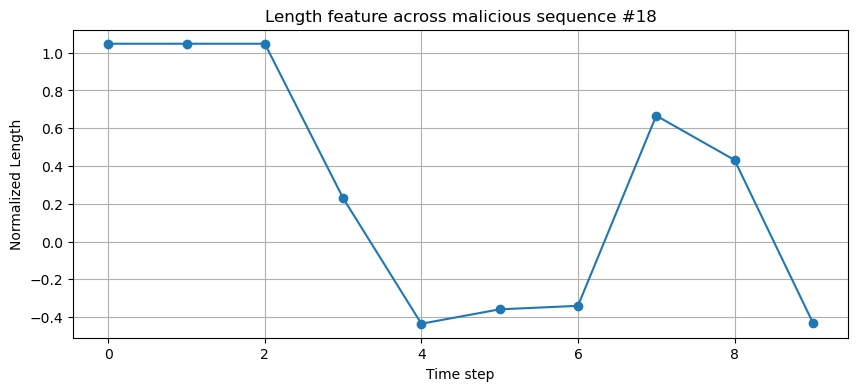

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(X[18][:, 3], marker='o')  # Example: plotting length feature
plt.title("Length feature across malicious sequence #18")
plt.xlabel("Time step")
plt.ylabel("Normalized Length")
plt.grid(True)
plt.show()


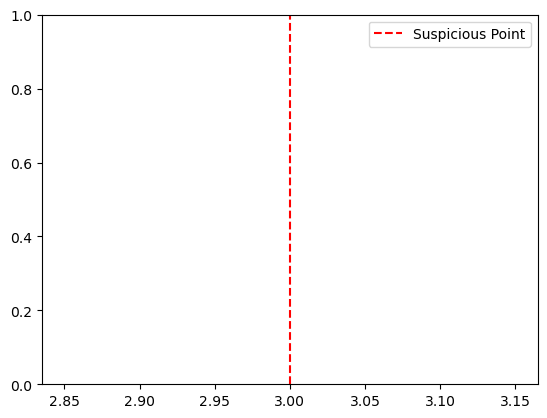

In [12]:
plt.axvline(x=3, color='red', linestyle='--', label='Suspicious Point')
plt.legend()


In [13]:
plt.savefig("malicious_sequence_18.png", dpi=300)


<Figure size 640x480 with 0 Axes>

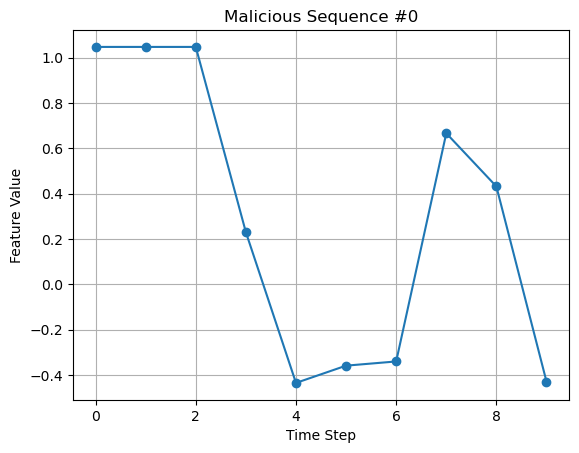

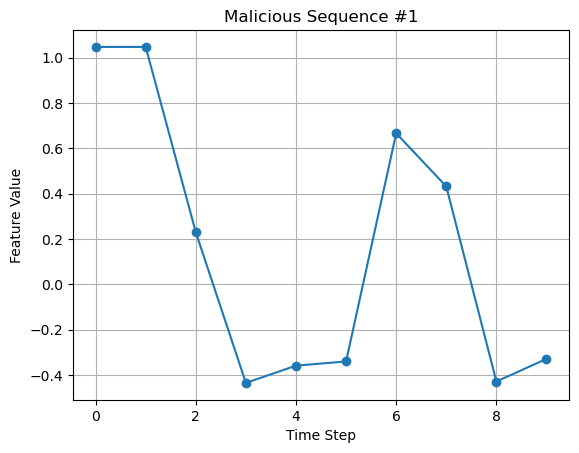

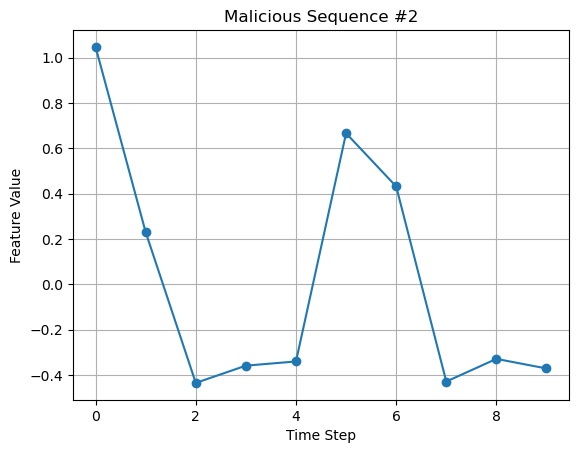

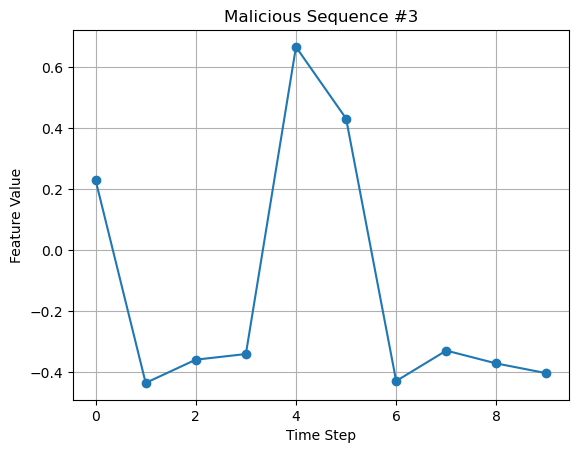

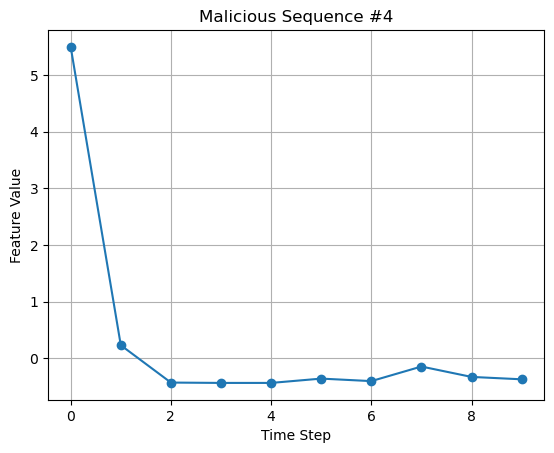

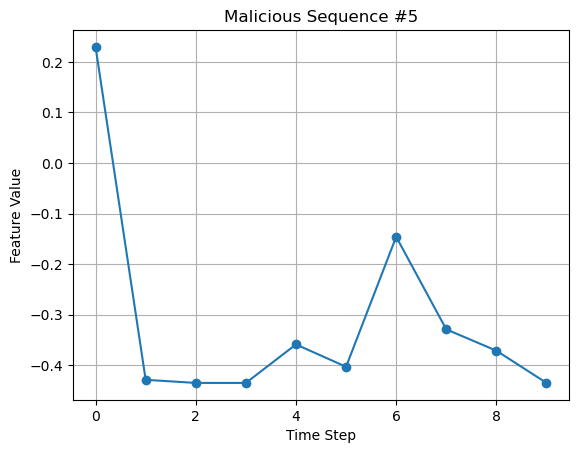

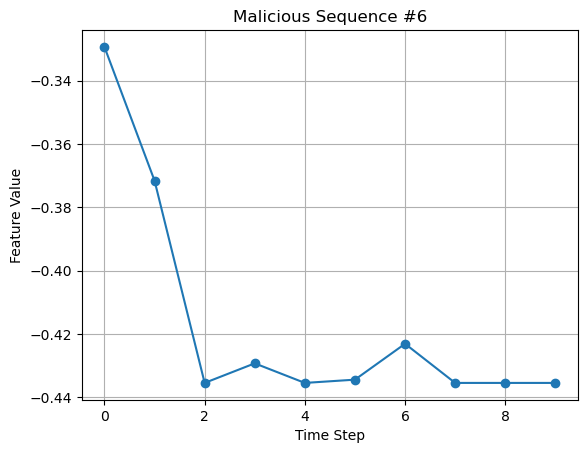

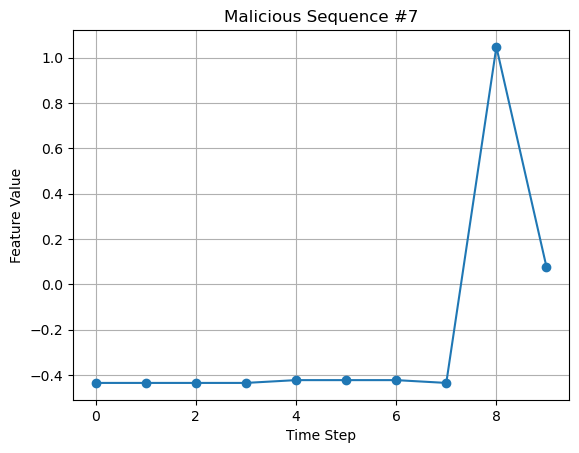

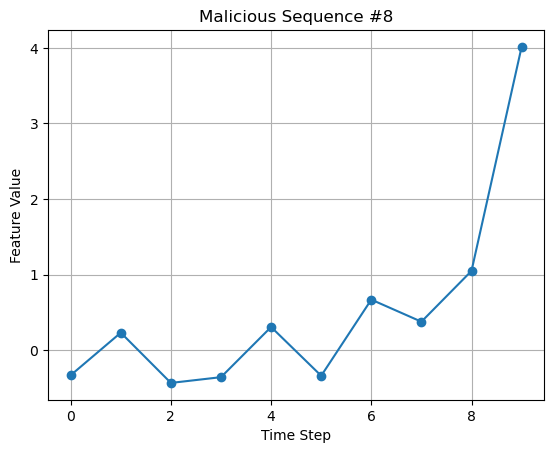

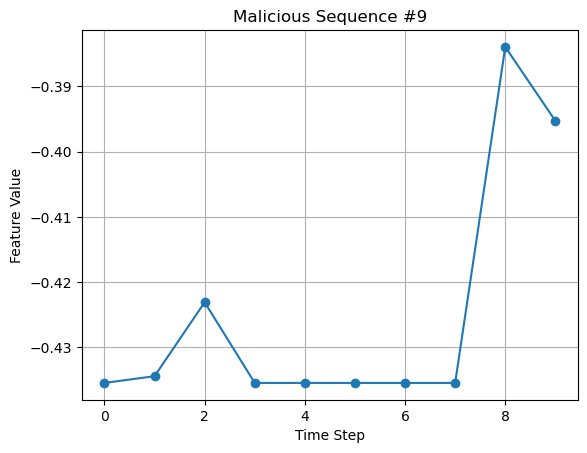

In [16]:
for idx, seq in enumerate(malicious_sequences):
    plt.plot(seq[:, -1], marker='o')
    plt.title(f"Malicious Sequence #{idx}")
    plt.xlabel("Time Step")
    plt.ylabel("Feature Value")
    plt.grid(True)
    plt.show()


In [17]:
for idx, seq in enumerate(malicious_sequences):
    print(f"Malicious Sequence #{idx} - Shape: {seq.shape}")


Malicious Sequence #0 - Shape: (10, 4)
Malicious Sequence #1 - Shape: (10, 4)
Malicious Sequence #2 - Shape: (10, 4)
Malicious Sequence #3 - Shape: (10, 4)
Malicious Sequence #4 - Shape: (10, 4)
Malicious Sequence #5 - Shape: (10, 4)
Malicious Sequence #6 - Shape: (10, 4)
Malicious Sequence #7 - Shape: (10, 4)
Malicious Sequence #8 - Shape: (10, 4)
Malicious Sequence #9 - Shape: (10, 4)


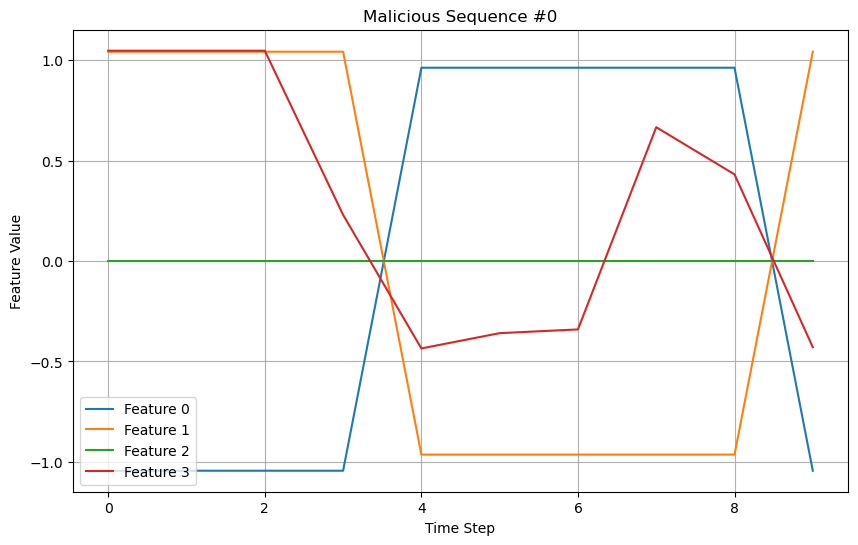

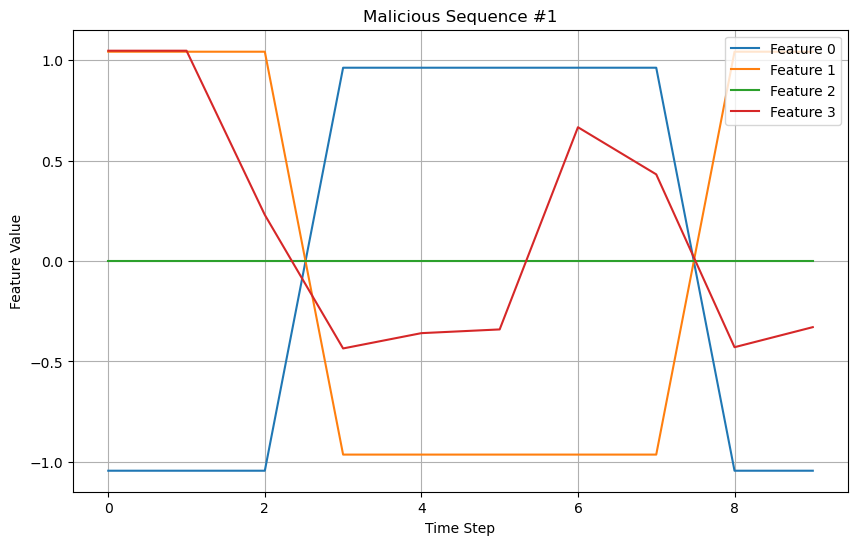

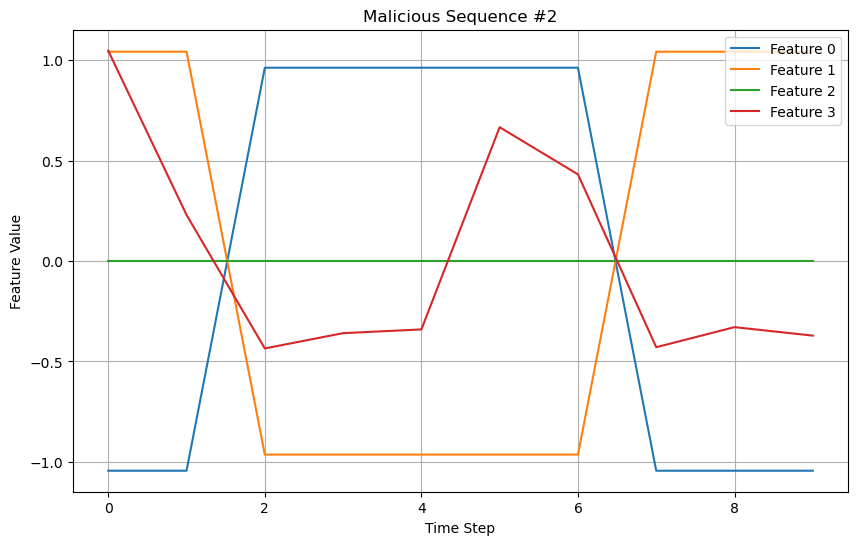

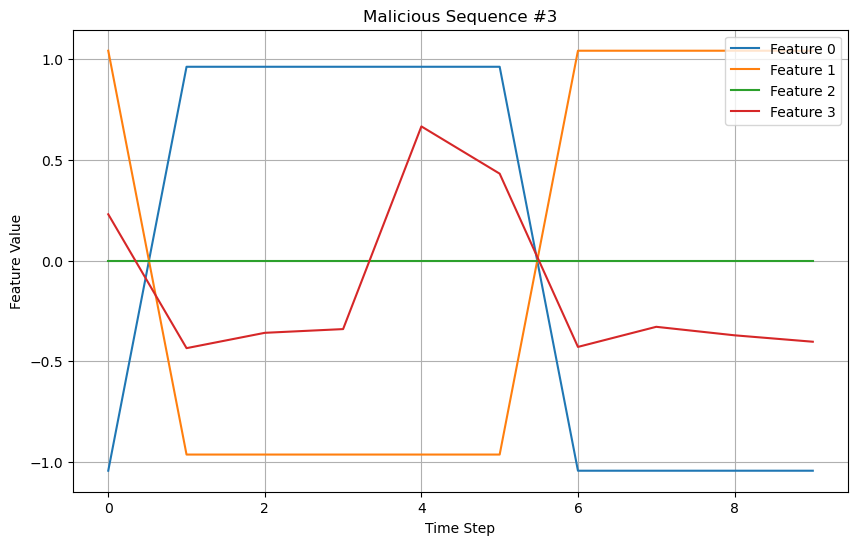

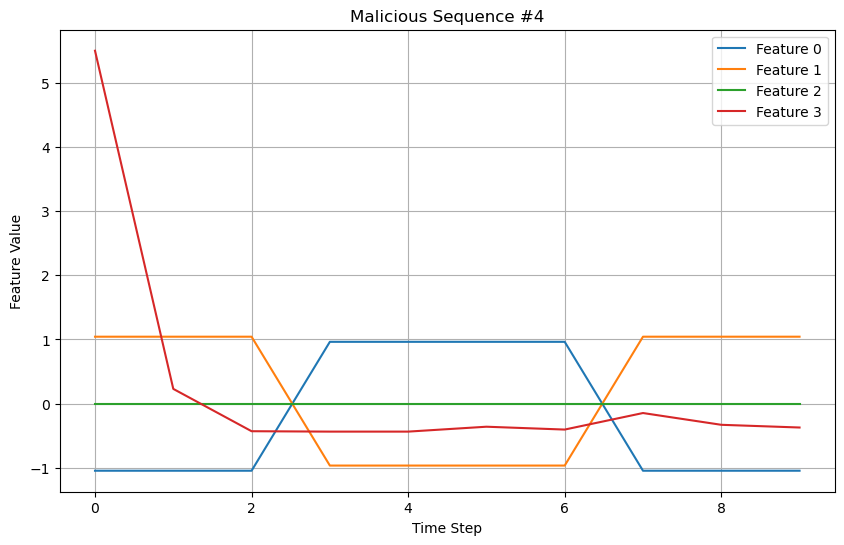

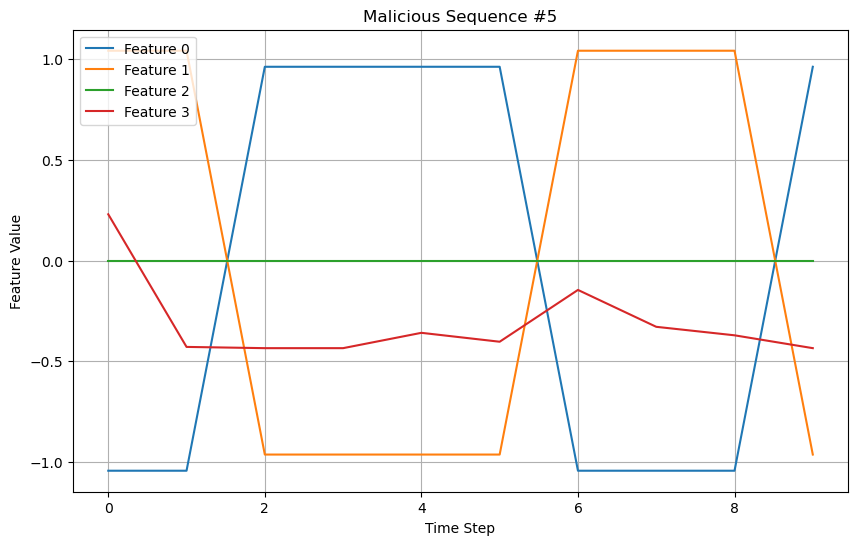

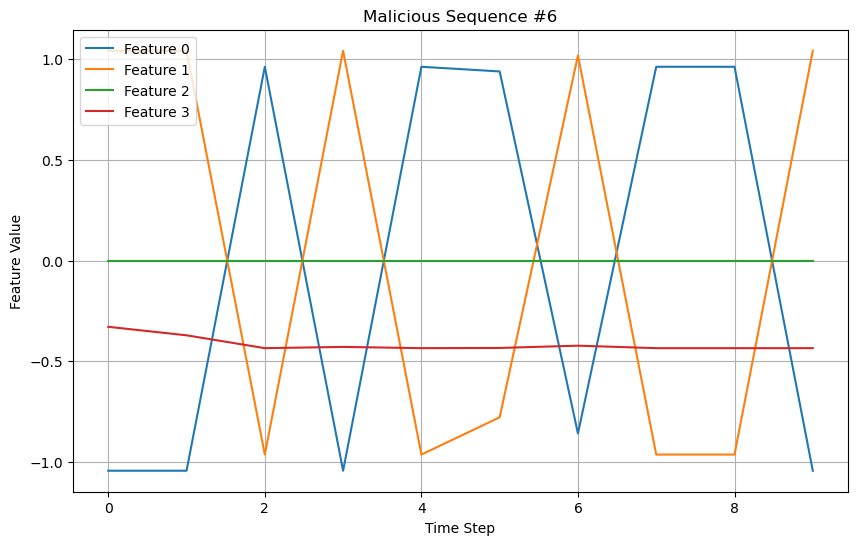

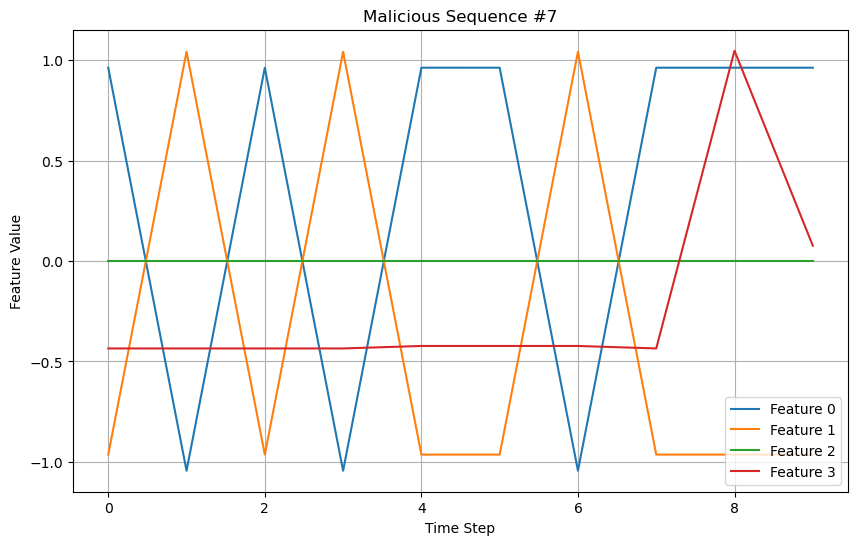

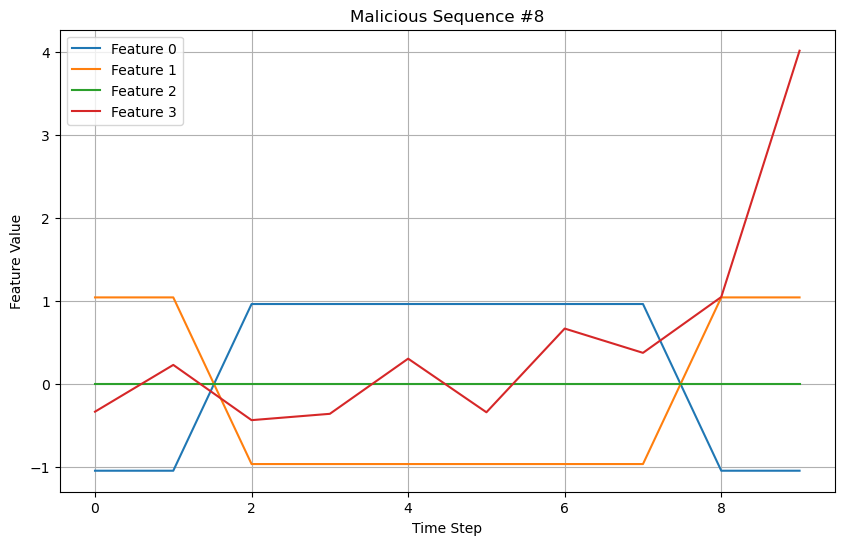

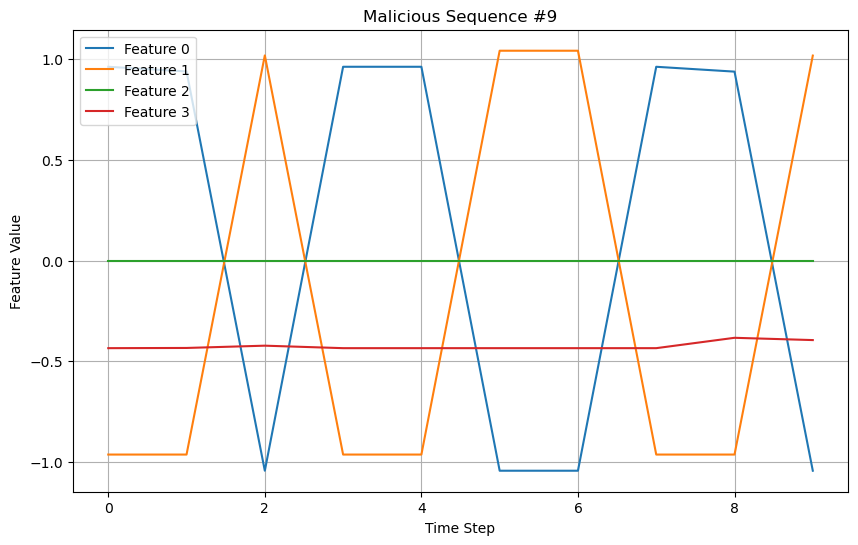

In [18]:
for idx, seq in enumerate(malicious_sequences):
    plt.figure(figsize=(10, 6))
    for i in range(seq.shape[1]):  # Loop through features
        plt.plot(seq[:, i], label=f"Feature {i}")
    plt.title(f"Malicious Sequence #{idx}")
    plt.xlabel("Time Step")
    plt.ylabel("Feature Value")
    plt.legend()
    plt.grid(True)
    plt.show()


In [20]:
# Define time_steps and num_features based on your data
time_steps = X_train.shape[1]  # Adjust if needed
num_features = X_train.shape[2]  # Adjust if needed

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, input_shape=(time_steps, num_features), return_sequences=False))
model.add(Dense(1, activation='sigmoid'))  # Binary classification (malicious or not)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\Deeksha B Poojary\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val),  # Now validation_data is defined
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.3125 - loss: 0.6971

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.4058 - loss: 0.6955 - val_accuracy: 0.8333 - val_loss: 0.6794
Epoch 2/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8750 - loss: 0.6777

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8859 - loss: 0.6759 - val_accuracy: 0.8889 - val_loss: 0.6623
Epoch 3/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9375 - loss: 0.6556

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9054 - loss: 0.6558 - val_accuracy: 0.8889 - val_loss: 0.6434
Epoch 4/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8438 - loss: 0.6468

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8780 - loss: 0.6370 - val_accuracy: 0.8889 - val_loss: 0.6219
Epoch 5/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8438 - loss: 0.6255

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8780 - loss: 0.6132 - val_accuracy: 0.8889 - val_loss: 0.5955
Epoch 6/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8438 - loss: 0.5837

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8741 - loss: 0.5803 - val_accuracy: 0.8889 - val_loss: 0.5630
Epoch 7/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8750 - loss: 0.5677

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8859 - loss: 0.5455 - val_accuracy: 0.8889 - val_loss: 0.5233
Epoch 8/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9062 - loss: 0.5150

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8898 - loss: 0.4994 - val_accuracy: 0.8889 - val_loss: 0.4788
Epoch 9/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9062 - loss: 0.4145

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8937 - loss: 0.4269 - val_accuracy: 0.8889 - val_loss: 0.4399
Epoch 10/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8750 - loss: 0.4372

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8819 - loss: 0.3961 - val_accuracy: 0.8889 - val_loss: 0.4205
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9093 - loss: 0.3262 - val_accuracy: 0.8889 - val_loss: 0.4253
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8663 - loss: 0.4077 - val_accuracy: 0.8889 - val_loss: 0.4230
Epoch 13/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8750 - loss: 0.3854

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8819 - loss: 0.3725 - val_accuracy: 0.8889 - val_loss: 0.4179
Epoch 14/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8750 - loss: 0.3752

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8859 - loss: 0.3631 - val_accuracy: 0.8889 - val_loss: 0.4003
Epoch 15/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8750 - loss: 0.3957

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8898 - loss: 0.3524 - val_accuracy: 0.8889 - val_loss: 0.3748
Epoch 16/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9062 - loss: 0.2998

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8937 - loss: 0.3247 - val_accuracy: 0.8889 - val_loss: 0.3581
Epoch 17/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8750 - loss: 0.3572

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8898 - loss: 0.3233 - val_accuracy: 0.8889 - val_loss: 0.3554
Epoch 18/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9015 - loss: 0.3059 - val_accuracy: 0.8889 - val_loss: 0.3585
Epoch 19/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9054 - loss: 0.3028 - val_accuracy: 0.8889 - val_loss: 0.3614
Epoch 20/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8741 - loss: 0.3518 - val_accuracy: 0.8889 - val_loss: 0.3624


In [24]:
model.save('my_model.keras')  # Save in Keras format


In [25]:
# Assuming X_test and y_test are your test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.1495
Test Accuracy: 1.0
Test Loss: 0.14947479963302612


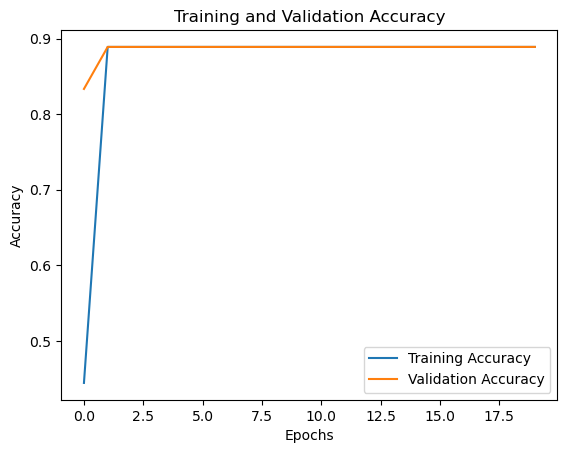

In [26]:
import matplotlib.pyplot as plt

# Assuming `history` is the training history object
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


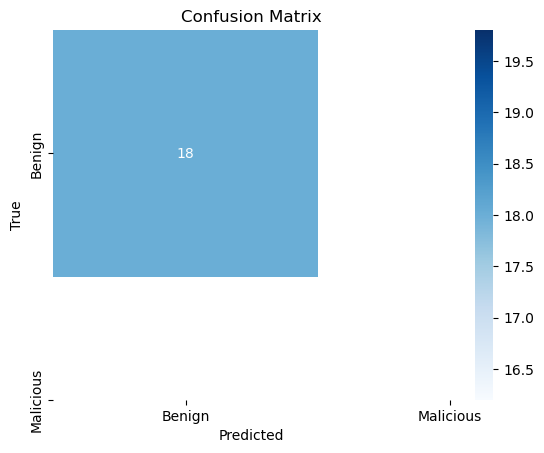

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Assuming binary classification

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Malicious"], yticklabels=["Benign", "Malicious"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_classes))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        18

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18

